# HVNM Small-Amplitude Oscillatory Shear (SAOS): Three Maxwell Modes + Reinforced Plateau

## Introduction

The **Hybrid Vitrimer Nanocomposite Model (HVNM)** extends the HVM by adding a fourth **interphase (I) subnetwork** that forms around nanoparticle surfaces. This creates a 4-subnetwork architecture: **P** (permanent covalent), **E** (exchangeable vitrimer BER), **D** (dissociative physical), and **I** (interphase around NPs). The model captures nanoparticle-filled vitrimers with dual TST kinetics (matrix and interfacial bond exchange), Guth-Gold strain amplification $X(\phi) = 1 + 2.5\phi + 14.1\phi^2$, and multi-timescale relaxation. When $\phi = 0$, the model recovers HVM exactly.

In SAOS, the HVNM exhibits **three Maxwell modes** (E, D, I networks) plus a reinforced permanent plateau $G_P X(\phi)$. The dual factor-of-2 appears: $\tau_{E,eff} = 1/(2k_{BER,0}^{mat})$ and $\tau_{I,eff} = 1/(2k_{BER,0}^{int})$ because both the E-network and I-network natural states evolve symmetrically with their distribution tensors.

> **Handbook:** See [HVNM Model Reference](../../docs/source/models/hvnm/hvnm.rst) for full constitutive equations and [Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) for multi-protocol fitting strategies and interphase characterization workflows.

## Learning Objectives

- Predict SAOS moduli for a 4-subnetwork vitrimer nanocomposite
- Identify $G_P X(\phi)$ from the low-frequency plateau
- Observe the dual factor-of-2: $\tau_{E,eff} = 1/(2k_{BER,0})$ and $\tau_{I,eff} = 1/(2k_{BER,0})$
- Understand $\phi$-dependent reinforcement and three loss peaks in $G''$

## Prerequisites
- Basic rheology (SAOS, storage/loss moduli)
- HVM fundamentals (see [HVM Notebooks](../hvm/))

## Estimated Runtime
- ~30 s (analytical predictions only)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory

The HVNM SAOS moduli are a superposition of three Maxwell modes plus a reinforced permanent plateau:

$$G'(\omega) = G_P X(\phi) + \frac{G_E \omega^2 \tau_{E,eff}^2}{1 + \omega^2 \tau_{E,eff}^2} + \frac{G_I \omega^2 \tau_{I,eff}^2}{1 + \omega^2 \tau_{I,eff}^2} + \frac{G_D \omega^2 \tau_D^2}{1 + \omega^2 \tau_D^2}$$

$$G''(\omega) = \frac{G_E \omega \tau_{E,eff}}{1 + \omega^2 \tau_{E,eff}^2} + \frac{G_I \omega \tau_{I,eff}}{1 + \omega^2 \tau_{I,eff}^2} + \frac{G_D \omega \tau_D}{1 + \omega^2 \tau_D^2}$$

where:
- $\tau_{E,eff} = 1/(2 k_{BER,0})$ (factor-of-2 for matrix exchange)
- $\tau_{I,eff} = 1/(2 k_{BER,0})$ (factor-of-2 for interphase exchange, same rate)
- $\tau_D = 1/k_d^D$ (dissociative relaxation)
- $X(\phi) = (1 + 2.5\phi + 14.1\phi^2)$ (Einstein-Batchelor reinforcement)

**Key features:**
- **Low-ω:** $G'(\omega \to 0) = G_P X(\phi)$ (reinforced permanent plateau)
- **High-ω:** $G'(\omega \to \infty) = G_P X(\phi) + G_E + G_I + G_D$ (total modulus)
- **Three loss peaks** in $G''$: one at $\omega \sim 1/\tau_{E,eff}$, one at $\omega \sim 1/\tau_{I,eff}$, one at $\omega \sim 1/\tau_D$

## 3. Model Setup

In [3]:
# Create full HVNM model
model = HVNMLocal()
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("phi", 0.1)
model.parameters.set_value("beta_I", 3.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-5)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

# Check effective relaxation times
tau_E = model.get_vitrimer_relaxation_time()
tau_I = model.get_interphase_relaxation_time()
tau_D = 1.0 / model.k_d_D
k_BER_0 = model.compute_ber_rate_at_equilibrium()
X = model.compute_strain_amplification()
regime = model.classify_vitrimer_regime()

print(f"k_BER_0 = {k_BER_0:.4f} 1/s")
print(f"τ_E_eff = 1/(2·k_BER_0) = {tau_E:.4f} s")
print(f"τ_I_eff = 1/(2·k_BER_0) = {tau_I:.4f} s")
print(f"τ_D     = 1/k_d_D      = {tau_D:.4f} s")
print(f"X(φ={model.phi}) = {X:.3f}")
print(f"G_P*X = {model.G_P * X:.0f} Pa")
print(f"G_I_eff = {model.G_I_eff:.1f} Pa")
print(f"Regime: {regime}")
print(f"Limiting case: {model.get_limiting_case()}")
print(f"Network fractions: {model.get_network_fractions_nc()}")

k_BER_0 = 0.0115 1/s
τ_E_eff = 1/(2·k_BER_0) = 43.4593 s
τ_I_eff = 1/(2·k_BER_0) = 1350.4308 s
τ_D     = 1/k_d_D      = 0.1000 s
X(φ=0.1) = 1.391
G_P*X = 6955 Pa
G_I_eff = 2309.6 Pa
Regime: rubbery
Limiting case: full HVNM (P + E + D + I)
Network fractions: {'f_P': 0.4840127356107299, 'f_E': 0.2087761620175686, 'f_D': 0.0695920540058562, 'f_I': 0.23761904836584535}


## 4. SAOS Prediction

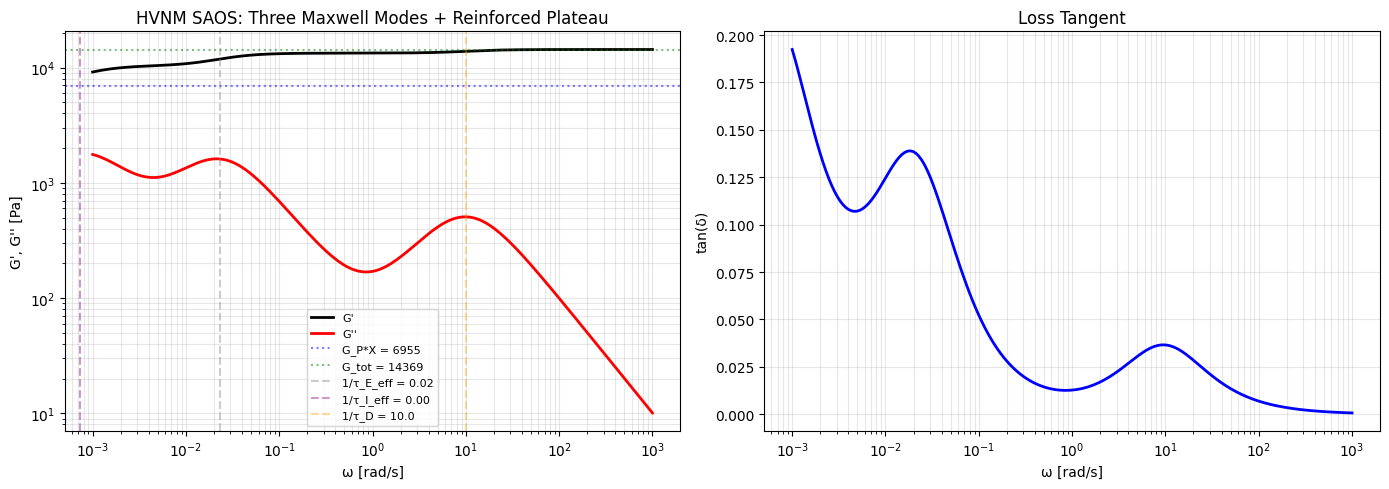

In [4]:
omega = np.logspace(-3, 3, 200)
G_prime, G_double_prime = model.predict_saos(omega)

X = model.compute_strain_amplification()
G_I_eff = model.G_I_eff
X_I = model.X_I
G_tot = model.G_P * X + model.G_E + G_I_eff * X_I + model.G_D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G', G'' vs omega
ax1.loglog(omega, G_prime, "k-", lw=2, label="G'")
ax1.loglog(omega, G_double_prime, "r-", lw=2, label="G''")
ax1.axhline(model.G_P * X, color="blue", ls=":", alpha=0.5, label=f"G_P*X = {model.G_P * X:.0f}")
ax1.axhline(G_tot, color="green", ls=":", alpha=0.5, label=f"G_tot = {G_tot:.0f}")
ax1.axvline(1/tau_E, color="gray", ls="--", alpha=0.4, label=f"1/τ_E_eff = {1/tau_E:.2f}")
ax1.axvline(1/tau_I, color="purple", ls="--", alpha=0.4, label=f"1/τ_I_eff = {1/tau_I:.2f}")
ax1.axvline(1/tau_D, color="orange", ls="--", alpha=0.4, label=f"1/τ_D = {1/tau_D:.1f}")
ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title("HVNM SAOS: Three Maxwell Modes + Reinforced Plateau")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# tan(delta)
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, "b-", lw=2)
ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("tan(δ)")
ax2.set_title("Loss Tangent")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Dual Factor-of-2 Demonstration

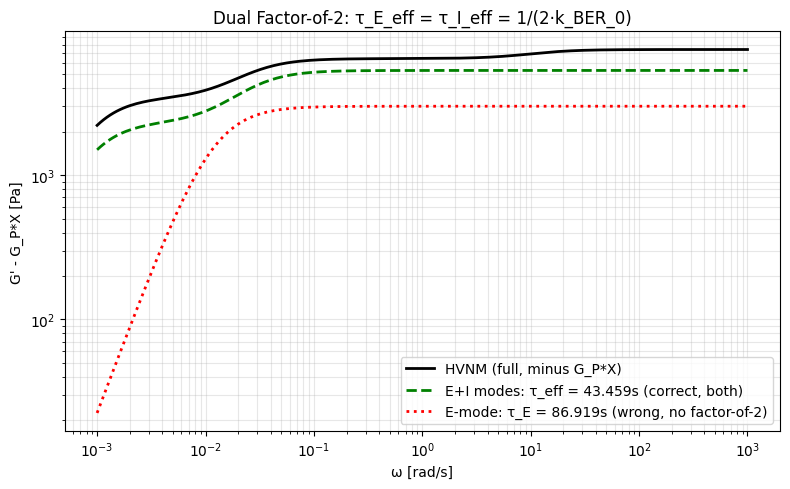

In [5]:
# Compare E-network and I-network contributions: both with factor-of-2
tau_E_naive = 1.0 / k_BER_0  # Without factor-of-2
tau_E_correct = tau_E          # With factor-of-2
tau_I_correct = tau_I          # With factor-of-2 (same rate)

G_E_prime_naive = model.G_E * (omega * tau_E_naive)**2 / (1 + (omega * tau_E_naive)**2)
G_E_prime_correct = model.G_E * (omega * tau_E_correct)**2 / (1 + (omega * tau_E_correct)**2)
G_I_val = model.G_I_eff  # Effective interphase modulus
G_I_prime_correct = G_I_val * (omega * tau_I_correct)**2 / (1 + (omega * tau_I_correct)**2)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime - model.G_P * X, "k-", lw=2, label="HVNM (full, minus G_P*X)")
ax.loglog(omega, G_E_prime_correct + G_I_prime_correct, "g--", lw=2, 
          label=f"E+I modes: τ_eff = {tau_E_correct:.3f}s (correct, both)")
ax.loglog(omega, G_E_prime_naive, "r:", lw=2, 
          label=f"E-mode: τ_E = {tau_E_naive:.3f}s (wrong, no factor-of-2)")
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G' - G_P*X [Pa]")
ax.set_title("Dual Factor-of-2: τ_E_eff = τ_I_eff = 1/(2·k_BER_0)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Nanoparticle Volume Fraction Sweep

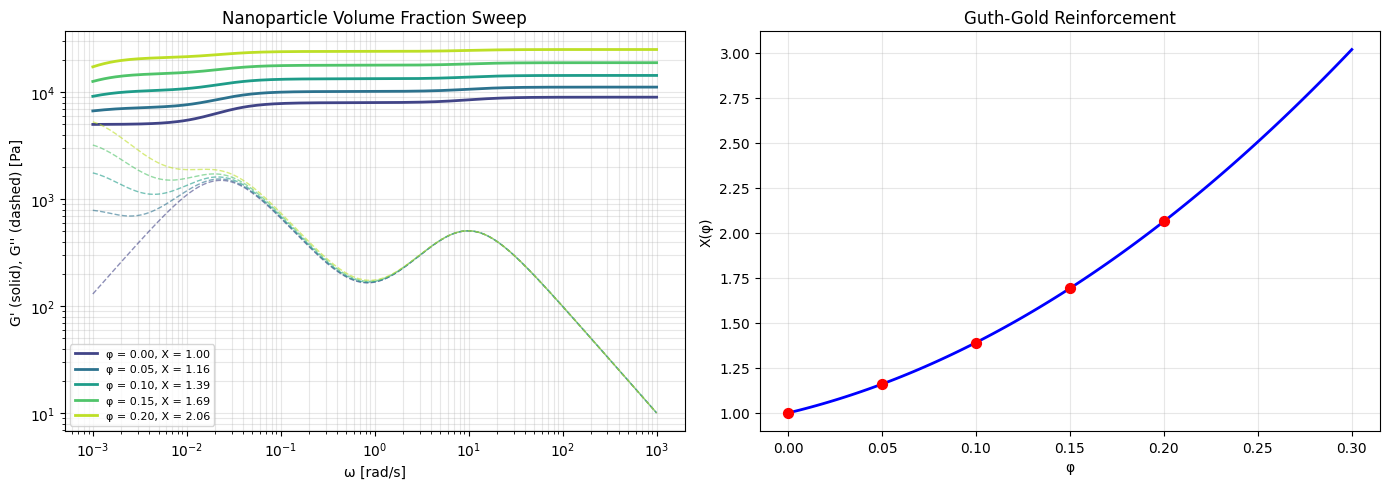

In [6]:
# Compare SAOS for different nanoparticle loadings
phi_values = [0.0, 0.05, 0.1, 0.15, 0.2]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(phi_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for phi_val, color in zip(phi_values, colors):
    model.parameters.set_value("phi", float(phi_val))
    G_p, G_dp = model.predict_saos(omega)
    X_phi = model.compute_strain_amplification()
    ax1.loglog(omega, G_p, "-", color=color, lw=2, 
               label=f"φ = {phi_val:.2f}, X = {X_phi:.2f}")
    ax1.loglog(omega, G_dp, "--", color=color, lw=1, alpha=0.6)

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' (solid), G'' (dashed) [Pa]")
ax1.set_title("Nanoparticle Volume Fraction Sweep")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# Reinforcement factor vs phi
phi_range = np.linspace(0, 0.3, 100)
X_range = np.array([1 + 2.5*p + 14.1*p**2 for p in phi_range])
ax2.plot(phi_range, X_range, "b-", lw=2)
ax2.scatter(phi_values, [1 + 2.5*p + 14.1*p**2 for p in phi_values], 
            c='red', s=50, zorder=5)
ax2.set_xlabel("φ")
ax2.set_ylabel("X(φ)")
ax2.set_title("Guth-Gold Reinforcement")
ax2.grid(True, alpha=0.3)

# Reset to original value
model.parameters.set_value("phi", 0.1)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Temperature Sweep (Dual Arrhenius)

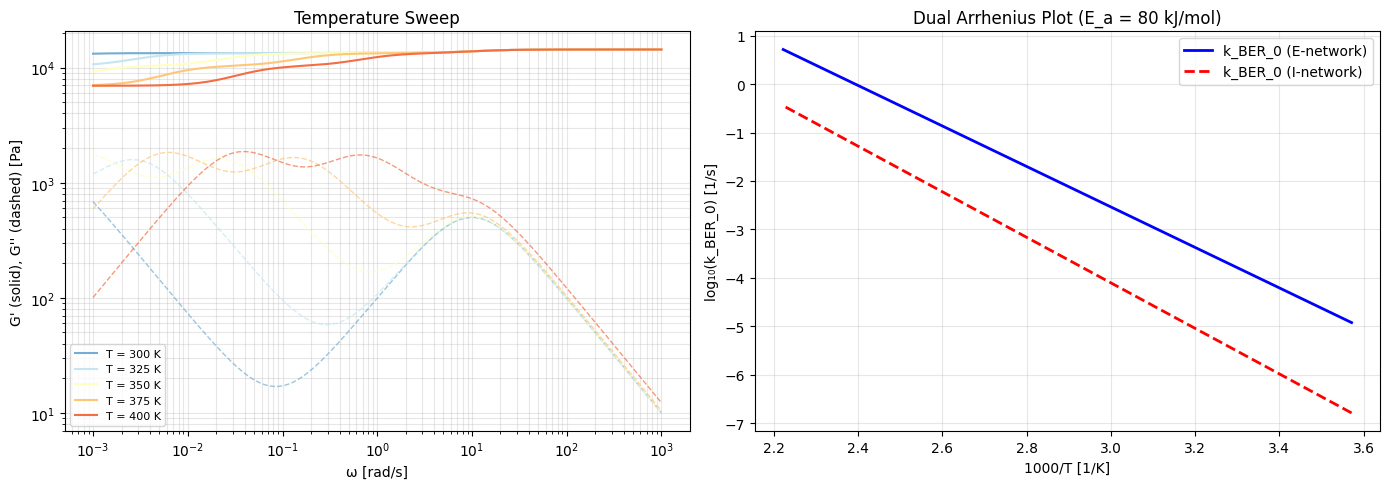

In [7]:
temperatures = [300, 325, 350, 375, 400]
colors = plt.cm.RdYlBu(np.linspace(0.8, 0.2, len(temperatures)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for T_val, color in zip(temperatures, colors):
    model.parameters.set_value("T", float(T_val))
    G_p, G_dp = model.predict_saos(omega)
    ax1.loglog(omega, G_p, "-", color=color, lw=1.5, label=f"T = {T_val} K")
    ax1.loglog(omega, G_dp, "--", color=color, lw=1, alpha=0.7)

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' (solid), G'' (dashed) [Pa]")
ax1.set_title("Temperature Sweep")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# Dual Arrhenius plot
model.parameters.set_value("T", 350.0)  # Reset
T_range = np.linspace(280, 450, 100)
inv_T, log_k_E, log_k_I = model.arrhenius_plot_data_dual(T_range)

ax2.plot(inv_T, log_k_E, "b-", lw=2, label="k_BER_0 (E-network)")
ax2.plot(inv_T, log_k_I, "r--", lw=2, label="k_BER_0 (I-network)")
ax2.set_xlabel("1000/T [1/K]")
ax2.set_ylabel("log₁₀(k_BER_0) [1/s]")
ax2.set_title(f"Dual Arrhenius Plot (E_a = {model.E_a/1e3:.0f} kJ/mol)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Limiting Cases Comparison

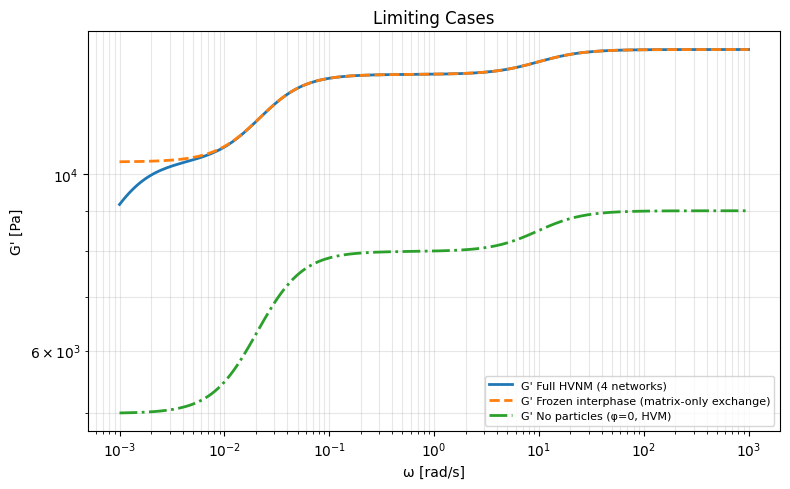

In [8]:
# Compare limiting cases
full = HVNMLocal()
full.parameters.set_value("G_P", 5000.0)
full.parameters.set_value("G_E", 3000.0)
full.parameters.set_value("G_D", 1000.0)
full.parameters.set_value("phi", 0.1)
full.parameters.set_value("beta_I", 3.0)
full.parameters.set_value("nu_0", 1e10)
full.parameters.set_value("E_a", 80e3)
full.parameters.set_value("V_act", 1e-5)
full.parameters.set_value("T", 350.0)
full.parameters.set_value("k_d_D", 10.0)

# Frozen interphase (matrix-only exchange)
frozen_interphase = HVNMLocal.matrix_only_exchange(
    G_P=5000, G_E=3000, G_D=1000, phi=0.1,
    nu_0=1e10, E_a=80e3, V_act=1e-5, T=350.0, k_d_D=10.0
)

# No particles (phi=0, recovers HVM)
no_particles = HVNMLocal.unfilled_vitrimer(
    G_P=5000, G_E=3000, G_D=1000,
    nu_0=1e10, E_a=80e3, V_act=1e-5, T=350.0, k_d_D=10.0
)

fig, ax = plt.subplots(figsize=(8, 5))
for m, label, ls in [
    (full, "Full HVNM (4 networks)", "-"),
    (frozen_interphase, "Frozen interphase (matrix-only exchange)", "--"),
    (no_particles, "No particles (φ=0, HVM)", "-."),
]:
    G_p, G_dp = m.predict_saos(omega)
    ax.loglog(omega, G_p, ls, lw=2, label=f"G' {label}")

ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G' [Pa]")
ax.set_title("Limiting Cases")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **$G'(\omega \to 0) = G_P X(\phi)$**: The reinforced permanent network provides a $\phi$-dependent low-frequency plateau
2. **Dual Factor-of-2**: Both $\tau_{E,eff} = 1/(2k_{BER,0})$ and $\tau_{I,eff} = 1/(2k_{BER,0})$ because $\mu^E, \mu^{E,nat}$ AND $\mu^I, \mu^{I,nat}$ relax toward each other
3. **Three loss peaks**: E-network at $\omega \sim 1/\tau_{E,eff}$, I-network at $\omega \sim 1/\tau_{I,eff}$, D-network at $\omega \sim 1/\tau_D$
4. **Guth-Gold reinforcement**: $X(\phi) = 1 + 2.5\phi + 14.1\phi^2$ increases plateau modulus with nanoparticle loading
5. **Dual Arrhenius**: Both matrix and interphase exchange rates follow $k_{BER,0}(T) = \nu_0 \exp(-E_a/RT)$

## Further Reading

**Handbook Documentation:**
- [HVNM Model Reference](../../docs/source/models/hvnm/hvnm.rst) — Full constitutive equations, parameter tables, and 4-subnetwork architecture
- [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) — Multi-protocol fitting strategies, interphase characterization workflows, and dual activation energy extraction
- [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) — Analytical solutions for SAOS, flow curves, and ODE formulations

**Key References:**
1. Karim, M.R., Vernerey, F. & Sain, T. (2025). "Constitutive Modeling of Vitrimers and Their Nanocomposites Based on Transient Network Theory." *Macromolecules*, 58(10), 4899-4912. [Dual TST kinetics, Guth-Gold amplification]
2. Vernerey, F.J., Long, R. & Brighenti, R. (2017). "A statistically-based continuum theory for polymers with transient networks." *J. Mech. Phys. Solids*, 107, 1-20. [VLB foundation]
3. Li, Z., Zhao, H., Duan, P., Zhang, L. & Liu, J. (2024). "Manipulating the Properties of Polymer Vitrimer Nanocomposites by Designing Dual Dynamic Covalent Bonds." *Langmuir*, 40(14), 7550-7560. [Experimental dual freezing temperatures]

## Next Notebooks

- **Notebook 02**: Stress relaxation — Quad-exponential decay + $G_P X$ plateau
- **Notebook 03**: Startup shear — Dual TST stress overshoot with amplified initial slope
- **Notebook 04**: Creep compliance — Three retardation modes, NP-reduced compliance